Examples I have in this notebook are drawn from [here](https://geohackweek.github.io/vector/06-geopandas-advanced/) and [here](http://andrewgaidus.com/Build_Query_Spatial_Database/) but using NHDPlus WBD polygons and NHDPlus flowlines for the PNW. 

First we'll import libraries we'll use in this example notebook

In [7]:
%matplotlib inline

import os
import json
import psycopg2
import osgeo.ogr

import matplotlib.pyplot as plt
# The two statements below are used mainly to set up a plotting
# default style that's better than the default from matplotlib
import seaborn as sns
plt.style.use('bmh')

import shapely
import shapely.wkt
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

Below we set up the connection to a local PostGIS NHDPlus database I have on my machine, as well as setting up a cursor object we'll use shortly

In [32]:
connection = psycopg2.connect(database="nhdplus", user="postgres",password="postgres",host="localhost",port="5432")
cursor = connection.cursor()

Below we have an example SQL query we pass to the database as a parameter in creation of a Geopandas GeoDataFrame. Note we have to define the coordinate reference system, it is not read by default from PostGIS.

In [49]:
sql= "SELECT * FROM wbd_subwatershed WHERE states = 'OR'"
wbd=gpd.GeoDataFrame.from_postgis(sql, connection, geom_col='geom',crs={'init': u'epsg:4326'})

Check out first feature using .iloc (could use wbd.head() also)

In [4]:
wbd.iloc[0]

gid                                                         793
objectid                                                  95489
huc_8                                                  17100306
huc_10                                               1710030604
huc_12                                             171003060402
acres                                                  0.246648
ncontrb_a                                                     0
hu_10_gnis                                                 None
hu_12_gnis                                                 None
hu_10_name                   Euchre Creek-Frontal Pacific Ocean
hu_10_mod                                                    NM
hu_10_type                                                    F
hu_12_ds                                           171003060500
hu_12_name                   Mussel Creek-Frontal Pacific Ocean
hu_12_mod                                                    NM
hu_12_type                              

Make a map of WBD polygons and color by 8-digit HUC number

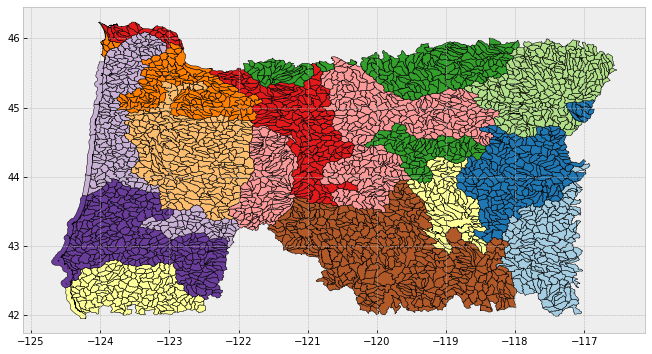

In [5]:
wbd.plot(column='huc_8', cmap='Paired', categorical=True, edgecolor='black', figsize=(14,6))

Now let's look at an example of taking a shapefile on disk and loading it into a PostGIS database.  Below I'm defining a table in PostGIS to hold shapefile I'll read in.

In [33]:
cursor.execute("DROP TABLE IF EXISTS flowlines")
cursor.execute("CREATE TABLE flowlines (id SERIAL PRIMARY KEY, comid VARCHAR NOT NULL, lengthkm NUMERIC, outline GEOGRAPHY)")

Create a spatial index for the outline field, which is necessary to make efficient spatial queries. Then commit the changes to the database.

In [34]:
cursor.execute("CREATE INDEX block_index ON flowlines USING GIST(outline)")
connection.commit()

Now that the table is created in the Postgres database, we can loop through features read in with GDAL / OGR and use cursor.execute() to run the SQL to convert python values to SQL and populate the table

In [35]:
shapefile = osgeo.ogr.Open("H:/NHDPlusV21/NHDPlusPN/NHDPlus17/NHDSnapshot/Hydrography/NHDFlowline.shp")
layer = shapefile.GetLayer(0)

#First delete the existing contents of this table in case we want to run the code multiple times.
cursor.execute("DELETE FROM flowlines")

for i in range(layer.GetFeatureCount()):
# for i in range(1,2,1):    
    feature = layer.GetFeature(i)
    comid = feature.GetField("COMID")
    lengthkm = feature.GetField("LENGTHKM")
    name = feature.GetField('GNIS_NAME')
    #Get feature geometry
    geometry = feature.GetGeometryRef()
    if name == 'Willamette River':
        #Convert geometry to WKT format
        wkt = geometry.ExportToWkt()
        #Insert data into database, converting WKT geometry to a PostGIS geography
        cursor.execute("INSERT INTO flowlines (comid, lengthkm, outline) VALUES ({}, {}, ST_GeogFromText('{}'))".format(comid, lengthkm, wkt))
connection.commit()    

In [43]:
sql= "SELECT * FROM wbd_subwatershed, flowlines WHERE st_intersects(wbd_subwatershed.geom, flowlines.outline)"

In [44]:
wbd_willamette=gpd.GeoDataFrame.from_postgis(sql, connection, geom_col='geom',crs={'init': u'epsg:4326'})

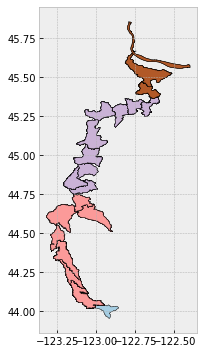

In [45]:
wbd_willamette.plot(column='huc_8', cmap='Paired', categorical=True, edgecolor='black', figsize=(14,6))

In [31]:
connection.close()

We can dissolve WBD HUC12 polygons using the HUC_8 field to make new HUC8 geodataframe.  We'll keep all the HUC ID and name fields in resulting dissolved geodataframe.

In [6]:
type(wbd)

geopandas.geodataframe.GeoDataFrame

In [69]:
huc8 = wbd.dissolve('huc_8')
len(huc8)

79

Re-apply crs to file (and verify it's missing first and it's back after)

In [70]:
print huc8.crs

{'init': u'epsg:4326'}


In [71]:
huc8.crs = wbd.crs
print huc8.crs

{'init': u'epsg:4326'}


Now plot the dissolved 8-digit HUC polygons-

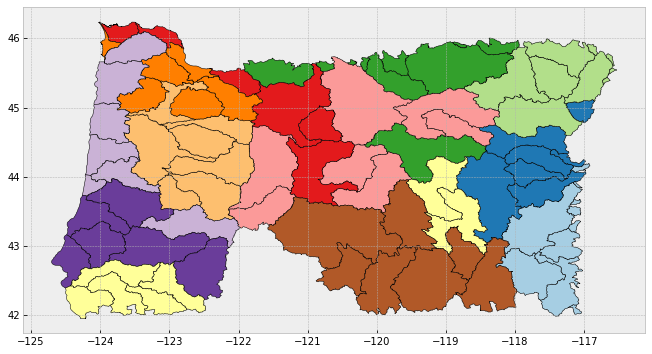

In [72]:
huc8.plot(cmap = 'Paired', categorical=True, edgecolor='black', figsize=(14,6));

Project to Oregon statewide Lambert projection - using pyepsg - and then reproject

In [74]:
huc8 = huc8.to_crs(epsg=2991)

Now plot the re-projected geodataframe

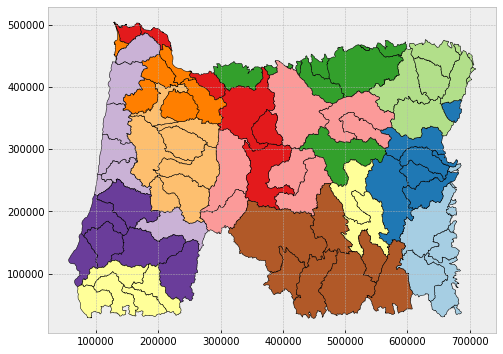

In [75]:
huc8.plot(cmap = 'Paired', categorical=True, edgecolor='black', figsize=(14,6));

Plot choropleth map using HUC area - and convert area to kilometers (map projection is in meters)

In [77]:
huc8['area_km2'] = huc8.geom.area * 1e-6
huc8.iloc[[0,1,2],[0,22]]

,geom,area_km2
huc_8,,
17050103,(POLYGON ((679446.0847084912 184070.6811281472...,386.085209
17050106,"POLYGON ((680084.8704586165 49496.81553381721,...",98.131472
17050107,"POLYGON ((664255.7335354562 39951.32383509733,...",2590.766262


Text(0.5,1,'Watersheds by area ($km^2$)')

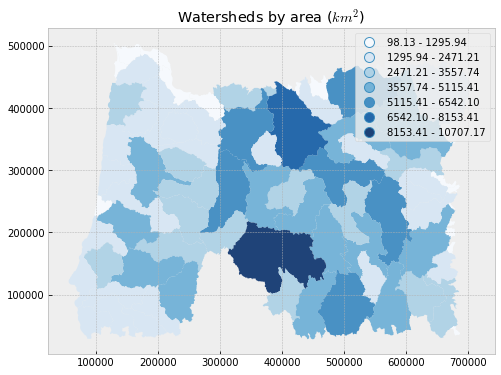

In [78]:
f, ax = plt.subplots(1, figsize=(8, 6))
huc8.plot(column='area_km2', scheme='fisher_jenks', k=7, 
                         alpha=0.9, cmap=plt.cm.Blues, legend=True,ax=ax)
plt.axis('equal')
ax.set_title('Watersheds by area ($km^2$)')

Try a spatial join of polygons on points - I'll use a set of USGS stream gages I have handy for the point layer.

In [79]:
gages = pd.read_csv('c:/users/mweber/temp/streamgages.csv')
gages.iloc[0]

SOURCE_FEA                          14361500
EVENTTYPE                         StreamGage
STATION_NM    ROGUE RIVER AT GRANTS PASS, OR
STATE                                     OR
LON_SITE                            -123.318
LAT_SITE                             42.4304
Name: 0, dtype: object

Promote the pandas dataframe to a geodataframe using the lattitude and longitude

In [80]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(gages.LON_SITE, gages.LAT_SITE)]
crs = {'init': 'epsg:4326'}
gages = GeoDataFrame(gages, crs=crs, geometry=geometry)
type(gages)

geopandas.geodataframe.GeoDataFrame

In [81]:
gages.iloc[0]

SOURCE_FEA                             14361500
EVENTTYPE                            StreamGage
STATION_NM       ROGUE RIVER AT GRANTS PASS, OR
STATE                                        OR
LON_SITE                               -123.318
LAT_SITE                                42.4304
geometry      POINT (-123.31783647 42.43039607)
Name: 0, dtype: object

Restrict gages to just Oregon, reproject the gages to the huc8 proojection, then rename the huc8 'geom' column to 'geometry' and then we'll try an inner spatial join

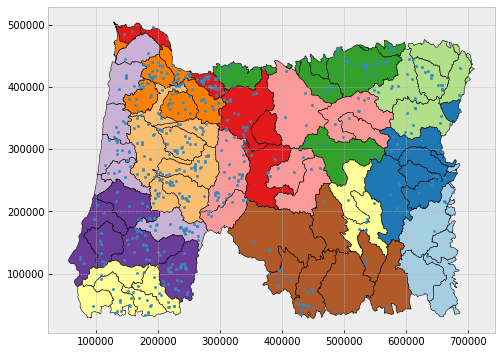

In [82]:
from geopandas.tools import sjoin
#gages = gages.to_crs(epsg=2991)
huc8 = huc8.rename(columns={'geom': 'geometry'}).set_geometry('geometry')
if not gages.crs == huc8.crs:
    gages = gages.to_crs(huc8.crs)
gages = gages.loc[gages['STATE']=='OR']
gages_huc8 = gpd.sjoin(gages, huc8, how='inner')
f, ax = plt.subplots(1, figsize=(8, 6))
plt.axis('equal')
huc8.plot(cmap = 'Paired', edgecolor='black',categorical=True, ax=ax)
gages_huc8.plot(markersize=6, categorical=True, ax=ax)

In [19]:
gages.crs == huc8.crs

False

Now run zonal statistics using polygons and rasters with rasterstats

In [83]:
import rasterio
import rasterio.plot as rioplot
import numpy as np
with rasterio.open('H:/WorkingData/Prism_30yr_OR.tif') as src:
    transform = src.meta['transform']
    precip = src.read(1)
precip[precip < 0] = np.nan

Look at raster metadata

In [84]:
src.meta

{'count': 1,
 'crs': CRS({u'lon_0': -96, u'datum': u'NAD83', u'y_0': 0, u'no_defs': True, u'proj': u'aea', u'x_0': 0, u'units': u'm', u'lat_2': 45.5, u'lat_1': 29.5, u'lat_0': 23}),
 'driver': u'GTiff',
 'dtype': 'float32',
 'height': 1187,
 'nodata': -9999.0,
 'transform': Affine(800.0, 0.0, -2472125.020833,
       0.0, -800.0, 3080024.0625),
 'width': 1259}

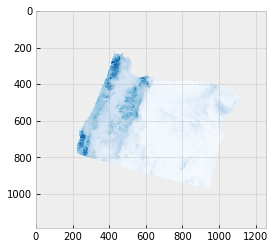

In [24]:
rioplot.show(precip, with_bounds=True, cmap=plt.cm.Blues)

In [85]:
from rasterstats import zonal_stats
import fiona
huc8 = huc8.to_crs('+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0')
precip_zonal = zonal_stats(huc8, 'H:/WorkingData/Prism_30yr_OR.tif', geojson_out=True)
# huc8['mean'] = pd.DataFrame(zonal_stats(vectors=huc8['geom'], raster='H:/WorkingData/Prism_30yr_OR.tif', stats='mean'))['mean']

In [86]:
precip_zonal = GeoDataFrame.from_features(precip_zonal)
precip_zonal.head(2)

,acres,area_km2,count,gaz_id,geometry,gid,globalid,hu_10_gnis,hu_10_mod,hu_10_name,...,huc_12,max,mean,meta_id,min,ncontrb_a,objectid,shape_area,shape_leng,states
0,22381.271444,386.085209,600,-72812,(POLYGON ((-1684470.024757544 2449556.42795410...,2553,{BC0BA51C-9970-43C3-A810-C6F12B99911A},None,NM,Lower Succor Creek,...,170501030901,620.897461,308.655677,OR01,229.144257,0.0,103018,0.010043,0.530808,OR
1,24225.748801,98.131472,154,-78734,POLYGON ((-1719043.984217515 2318687.346051499...,8475,{BF6E742F-F812-4F50-AF09-B55A52CAE3CC},None,NM,Tent Creek,...,170501060502,367.764740,327.508903,OR01,313.125732,0.0,220900,0.010666,0.628540,OR


In [92]:
precip_zonal.crs = '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0'

Now a choropleth map of 30-year average precip by 8-digit HUC in Oregon

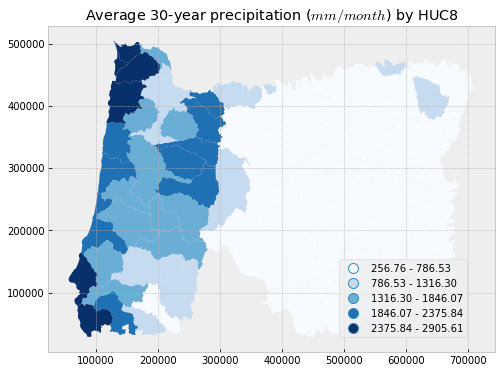

In [101]:
precip_zonal = precip_zonal.to_crs(epsg=2991)
f, ax = plt.subplots(1, figsize=(8, 6))
precip_zonal.plot(column='mean', scheme='Equal_Interval', k=5, 
                   alpha=1, cmap=plt.cm.Blues, legend=True, ax=ax)
plt.axis('equal')
ax.set_title('Average 30-year precipitation ($mm/month$) by HUC8');
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.95, 0.3, 0, 0))